In [1]:
# modified from https://kyso.io/eoin/democracy-vs-gdp-per-capita

gdp_link = 'http://api.worldbank.org/v2/en/indicator/NY.GDP.PCAP.CD?downloadformat=excel'
eiu_link = 'http://www.gapm.io/dxlsdemocrix'

In [2]:
import os
import requests

def download(url, filename):
    r = requests.get(url)
    f = open(filename, 'wb')
    for chunk in r.iter_content(chunk_size=512 * 1024): 
        if chunk: # filter out keep-alive new chunks
            f.write(chunk)
    f.close()
    return

def download_if_not_exists(url, filename):
    if os.path.exists(filename):
        return
    download(url, filename)

In [3]:
download_if_not_exists(gdp_link, '/tmp/gdp.xls')
download_if_not_exists(eiu_link, '/tmp/eiu.xls')

In [4]:
%%capture
!pip install xlrd

In [5]:
import pandas as pd

df_gdp = pd.read_excel('/tmp/gdp.xls', skiprows=3)
df_gdp = df_gdp.set_index('Country Name')

df_dem = pd.read_excel('/tmp/eiu.xls', sheet_name='data-for-countries-etc-by-year')

In [6]:
df_dem['Country Code'] = list(map(lambda x: str(x).upper(), df_dem['geo']))

In [7]:
year = 2018
year_str = '{}'.format(year)

In [8]:
df_dem = df_dem[df_dem['time'] == year][['Democracy index (EIU)', 'Country Code']]

In [9]:
df = df_gdp[['Country Code', year_str]]
df = pd.merge(df, df_dem, on="Country Code", right_index=True)
df = df.rename(columns={ year_str: 'GDP Per Capita' })

In [10]:
df.head()

,Country Code,GDP Per Capita,Democracy index (EIU)
Country Name,,,
Afghanistan,AFG,520.896603,29.7
Angola,AGO,3432.385736,36.2
Albania,ALB,5253.630064,59.8
United Arab Emirates,ARE,43004.948646,27.6
Argentina,ARG,11652.566290,70.2


In [11]:
df_gdp[df_gdp['Country Code'] == 'CHN']

,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Country Name,,,,,,,,,,,,,,,,,,,,,
China,CHN,GDP per capita (current US$),NY.GDP.PCAP.CD,89.520542,75.805838,70.909412,74.313643,85.498555,98.486778,104.324566,...,3832.235952,4550.453596,5618.132491,6316.918863,7050.64592,7651.366044,8033.388043,8078.790474,8759.041578,9770.847088


In [12]:
df_dem[df_dem['Country Code'] == 'TWN']

,Democracy index (EIU),Country Code
1884,77.3,TWN


In [13]:
%%capture
!pip install country_converter --upgrade
!pip install cufflinks --upgrade

In [14]:
import country_converter as coco
import numpy as np
import cufflinks as cf
from plotly.offline import init_notebook_mode, iplot

In [15]:
#init_notebook_mode(connected=True)
cf.set_config_file(offline=True)

In [16]:
_Asia = ["Israel", "United Arab Emirates", "Singapore", "Thailand", "Taiwan Province of China",
                                   "Qatar", "Saudi Arabia", "Kuwait", "Bahrain", "Malaysia", "Uzbekistan", "Japan",
                                   "South Korea", "Turkmenistan", "Kazakhstan", "Turkey", "Hong Kong S.A.R., China", "Philippines",
                                   "Jordan", "China", "Pakistan", "Indonesia", "Azerbaijan", "Lebanon", "Vietnam",
                                   "Tajikistan", "Bhutan", "Kyrgyzstan", "Nepal", "Mongolia", "Palestinian Territories",
                                   "Iran", "Bangladesh", "Myanmar", "Iraq", "Sri Lanka", "Armenia", "India", "Georgia",
                                   "Cambodia", "Afghanistan", "Yemen", "Syria"]

_Europe = ["Norway", "Denmark", "Iceland", "Switzerland", "Finland",
                                   "Netherlands", "Sweden", "Austria", "Ireland", "Germany",
                                   "Belgium", "Luxembourg", "United Kingdom", "Czech Republic",
                                   "Malta", "France", "Spain", "Slovakia", "Poland", "Italy",
                                   "Russia", "Lithuania", "Latvia", "Moldova", "Romania",
                                   "Slovenia", "North Cyprus", "Cyprus", "Estonia", "Belarus",
                                   "Serbia", "Hungary", "Croatia", "Kosovo", "Montenegro",
                                   "Greece", "Portugal", "Bosnia and Herzegovina", "Macedonia",
                                   "Bulgaria", "Albania", "Ukraine"]
_Oceania = ["New Zealand", "Australia"]

_North_America = ["Canada", "Costa Rica", "United States", "Mexico",  
                                   "Panama","Trinidad and Tobago", "El Salvador", "Belize", "Guatemala",
                                   "Jamaica", "Nicaragua", "Dominican Republic", "Honduras",
                                   "Haiti"]
_South_America = ["Chile", "Brazil", "Argentina", "Uruguay",
                                   "Colombia", "Ecuador", "Bolivia", "Peru",
                                   "Paraguay", "Venezuela"]

Asia = coco.convert(names=_Asia, to='iso3', not_found=None)
Europe = coco.convert(names=_Europe, to='iso3', not_found=None)
Oceania = coco.convert(names=_Oceania, to='iso3', not_found=None)
North_America = coco.convert(names=_North_America, to='iso3', not_found=None)
South_America = coco.convert(names=_South_America, to='iso3', not_found=None)

In [17]:
def GetConti(country):
    if country in Asia:
        return "Asia"
    elif country in Europe:
        return "Europe"
    elif country in North_America:
        return "North America"
    elif country in South_America:
        return "South America"
    elif country in Oceania:
        return "Oceania"
    else:
        return "Africa"
    

df['Continent'] = df['Country Code'].apply(lambda x: GetConti(x))
df['Country Name'] = coco.convert(names=df['Country Code'].tolist(), to='name_short', not_found=None)
df['Log GDP Per Capita'] = np.log10(df['GDP Per Capita'])

In [18]:
df[df['Log GDP Per Capita'] > 0].iplot(
    mode='markers',
    x='Log GDP Per Capita',
    y='Democracy index (EIU)',
    categories='Continent',
    text='Country Name',
    xTitle='Log GDP Per Capita (Current USD)',
    yTitle='EIU Democracy Index',
    theme='white',
)

In [19]:
countries_to_show_name = [
    'China',
    'Hong Kong',                                                                    
    'Singapore',                                                                    
    'Japan',                                                                        
    'United Kingdom',                                                               
    'United States',                                                                
    'Germany',                                                                     
    'Malaysia',                                                                     
    'Qatar',                                                                        
    'South Korea',                                                                  
    'Russia' 
]

filters = (df['Log GDP Per Capita'] > 4)
for c in countries_to_show_name:
    filters |= (df['Country Name'] == c)

In [20]:
figure = df[filters].iplot(
    mode='markers+text',
    x='GDP Per Capita',
    y='Democracy index (EIU)',
    categories='Country Name',
    text='Country Name',
    xTitle=('GDP Per Capita, USD in Log Scale (World Bank)<br> '
            'Optimistically assuming China grows at 8% per year, '
            'China is about 21 years behind HK today.'
           ),
    logx=True,
    yTitle='Democracy Index (The Economist, Intelligence Unit)',
    theme='white',
    title='Political and Economic power, per person, {}.'.format(year_str),
    asFigure=True,
    showlegend=False,
)

In [21]:
figure_json = figure.to_plotly_json()

special_colors = {
    'China': 'crimson',
    'Hong Kong': 'navy',
}
for d in figure_json['data']:
    textposition = 'bottom center'
    if d['name'] == 'United Kingdom':
        textposition = 'top left'
    elif d['name'] == 'South Korea':
        textposition = 'top center'
    elif d['name'] == 'Malaysia':
        textposition = 'bottom left'        
    d['textposition'] = textposition
    
    
    if d['name'] == 'China' or d['name'] == 'Hong Kong':
        d['textfont']['color'] = special_colors[d['name']]
        d['textfont']['size'] = 18
    
    if d['name'] not in countries_to_show_name:
        d['text'] = ''
figure = figure.update(figure_json)

In [22]:
figure.iplot(filename='pol_econ_power', asImage=True)

![](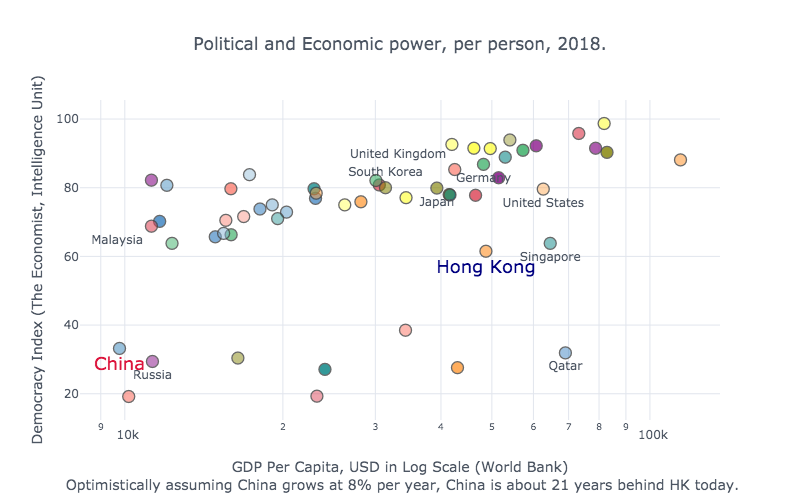

In [23]:
import math

def get_catch_up_msg(a, b, growth_a, growth_b, base_a, base_b):
    num_years = math.log(base_b / base_a, ((100 + growth_a) / (100 + growth_b)))
    msg = (
        'Assume {a} grows at {growth_a}%, {b} {growth_b}%, '
        'it would take {a} {0:.2f} years to catch up.'
    )
    return msg.format(num_years, **locals())
    
print(get_catch_up_msg('China', 'Hong Kong', 8, 0, 10000, 49000))
print(get_catch_up_msg('China', 'Hong Kong', 8, 2, 10000, 49000))

Assume China grows at 8%, Hong Kong 0%, it would take China 20.65 years to catch up.
Assume China grows at 8%, Hong Kong 2%, it would take China 27.80 years to catch up.


> Taiwan, China, is not listed as a separate country for World Development Indicators. 
> For most indicators, Taiwan, China, data is not added to the data for China, 
> but Taiwan, China, is added to the world aggregate and the high-income countries aggregate.
>
> -- <cite>[World Bank](https://datahelpdesk.worldbank.org/knowledgebase/articles/114933-where-are-your-data-on-taiwan) </cite>

In [24]:
def get_num_years_to_current_level(current_level, starting_level, starting_rate, rate_decrease_per_ten_years):
    level = starting_level
    rate = starting_rate
    for idx, _ in enumerate(range(100)):
        level *= (1 + rate / 100)
        if idx % 10 == 0 and idx > 0:
            rate -= rate_decrease_per_ten_years
            if rate < 0:
                break
        if level > current_level:
            return(idx)


In [25]:
print(get_num_years_to_current_level(49000, 10000, 8, 2))

25


In [26]:
def get_level_after_thirty_years(starting_level, starting_rate, rate_decrease_per_ten_years):
    level = starting_level
    rate = starting_rate
    for idx in range(30):
        level *= (1 + rate / 100)
        if idx % 10 == 0 and idx > 0:
            rate -= rate_decrease_per_ten_years
    return level

In [27]:
print(get_level_after_thirty_years(10000, 8, 2))

59431.95502551923


In [28]:
49000 * 1.02 ** 30

88756.71762106438